# Still et al. (2022) energy balance model specification

Keenan Ganz

## Overview of leaf energy balance

All leaf energy balance models operate under the assumption that the amount of energy (expressed as W/m$^2$) entering a leaf equals that exiting the leaf. Two sources of energy enter the leaf: downwelling longwave radation and downwelling shortwave radiation. Three sources of energy exit the leaf: upwelling longwave radiation, sensible heat, and latent heat. We can write this relationship as:

$$
LW_{in} + SW_{in} = LW_{out} + H + \lambda E
$$

Under most environmental conditions, the sensible heat flux is small and can be ignored. The radiation terms are often collected on one side of the equation as $R_n = LW_{in} + SW_{in} - LW_{out}$. Each energy source can be parameterized in terms of leaf characteristics and environmental inputs as

$$
\begin{align}
LW_{in} &= \epsilon LW_{\downarrow} \newline
SW_{in} &= \alpha (SW_{\downarrow} - SW_{\uparrow}) \newline
LW_{out} &= \epsilon \sigma T_{leaf}^4 \newline
\lambda E &= g_{tot} \lambda \frac{e(T_{leaf}) - e(T_{air})RH}{P_a}
\end{align}
$$

where symbols are as listed below.

| Symbol | Name | Value | Unit |
| :-- | :- | -: | :-: |
| $LW_{\downarrow}$ | Downwelling longwave radiation | $-$ | $\mathrm{\frac{W}{m^2}}$ |
| $SW_{\downarrow}$ | Downwelling shortwave radiation | $-$ | $\mathrm{\frac{W}{m^2}}$ |
| $SW_{\uparrow}$ | Reflected shortwave radiation | $-$ | $\mathrm{\frac{W}{m^2}}$ |
| $\epsilon$ | Leaf emissivity | $0.98$ | $-$ |
| $\alpha$ | Leaf absorptance | $0.50$ | $-$ |
| $\sigma$ | Stefan-Boltzmann constant | $5.67 \times 10^{-8}$ | $\mathrm{\frac{W}{m^2 K^4}}$ |
| $T_{leaf}$ | Leaf temperature | $-$ | $\mathrm{K}$ |
| $T_{air}$ | Air temperature | $-$ | $\mathrm{K}$ |
| $\lambda E$ | Latent heat flux | $-$ | $\mathrm{\frac{W}{m^2}}$ |
| $g_{tot}$ | Total leaf conductance to water vapor | $-$ | $\mathrm{\frac{mol}{m^2 s}}$ |
| $\lambda$ | Heat of vaporization of water | $40.66 \times 10^3$ | $\mathrm{\frac{J}{mol}}$ |
| $e(T)$ | Saturation vapor pressure at temperature $T$ | $-$ | $\mathrm{kPa}$ |
| $P_a$ | Atmospheric pressure | $-$ | $\mathrm{kPa}$ |
| $RH$ | Relative humidity | $-$ | % |

Under this parameterization, $T_{leaf}$ appears in both the latent heat flux term and the outgoing longwave radation term so it cannot be solved for directly. Instead, one must use numerical methods to find a value for $T_{leaf}$ that satisfies energy balance.

## Modifications by Still et al. (2022)

The source paper makes some modifications to the classic energy balance model that make it possible to solve for leaf temperature directly and provide additional model outputs. First, the authors define a net *isothermal* radiation that corresponds to air at the skin surface of the leaf.

$$
R_{niso} = \alpha(SW_{\downarrow} - SW_{\uparrow}) + \epsilon LW_{\downarrow} - \epsilon \sigma T_{air}^4
$$

Next, they define the total conductance of the leaf as the serial sum of stomatal and boundary layer conductance to water vapor. It is assumed that boundary layer conductance to water vapor is 1.08 times that of boundary layer conductance to heat, which is estimated for needleleaf trees as

$$
g_{bH} = 0.006 \rho_{mol} \frac{u^{0.6}}{d^{0.4}}
$$

where $\rho_{mol}$ is the molar density of air (i.e. $\mathrm{\frac{mol}{m^3}}$), $u$ is wind speed, and $d$ is the characteristic leaf dimension (assumed to be 1 cm for needles). The authors were also interested in modeling whether the latent heat flux was determined by the physical parameters of the air or by stomatal conductance. To do so, they defined a leaf conductance to radiative heat transfer as

$$
g_R = 2 \rho_{mol} \frac{4 \epsilon \sigma T_{air}^3}{\rho c_p}
$$

where $\rho$ is the mass density of air (i.e. $\mathrm{\frac{kg}{m^3}}$) and $c_p$ is the heat capacity of dry air, taken as 1,010 $\mathrm{\frac{J}{kg K}}$. The decoupling coefficient $\Omega$ describes the degree of coupling between leaf temperature and air temperature and is defined as

$$
\Omega = \frac{k + 2 + \frac{g_R}{g_{bH}}} {k + \frac{g_R + g_{bH}}{g_s} + \frac{g_R}{g_{bH}}}
$$

where $k$ is the ratio of $\frac{\partial e}{\partial T_{air}}$ to the psychrometric constant. In the case where $\Omega = 1$, leaf temperature is totally decoupled from the air and the latent heat flux is limited by the available radiation. This equilibrium heat flux is written as

$$
\lambda E_{eq} = \frac{k R_{niso}}{k + 1 + \frac{g_R}{g_{bH}}}.
$$

On the other hand, when $\Omega = 0$ leaves are totally coupled with air and the latent heat flux is determined ("imposed") by stomatal conductance as in the typical latent heat flux formulation written above.

$$
\lambda E_{imp} = g_{tot} \lambda \frac{e(T_{leaf}) - e(T_{air})RH}{P_a}
$$

The two latent heat flux endpoints are related to observed latent heat flux with $\Omega$.

$$
\lambda E = \Omega \lambda E_{eq} + (1 - \Omega) \lambda E_{imp}
$$

The authors then combine all these expressions into a single solution for $T_{leaf}$:

$$
T_{leaf} = T_{air} + \frac{g_{bH}}{g_{bH} + g_R} \frac{R_{niso} - \lambda E}{c_p M_{air} g_{bH}}
$$

where $M_{air}$ is the molar mass of air.

A few notes about the behavior of the model are clear from its formulation. First, leaf temperature should track very closely with $T_{air}$. The model describes when leaf temperature deviates from air temperature rathern than an absolute temperature. Second, we can see that leaf thermoregulation (i.e. $T_{leaf} < T_{air}$) occurs only when $\lambda E > R_{niso}$. Since $\lambda E_{eq}$ is multiplied by $R_{niso}$ and a factor that is strictly less than 1, we would only expect thermoregulation to occur when leaves are decoupled from air and $\lambda E_{imp}$ dominates.

## Model implementation

The model is quite complex with many options for customization. We therefore take a top-down approach with mix-ins. The model is written in `leaf_eb_still.jl`. This notebook demonstrates each subsystem and the overall temperature calculation.

In [1]:
if occursin("notebooks", pwd())
    cd("..") 
end

pwd()

"G:\\Other computers\\My Laptop\\UW\\Classes\\SEFS508\\Project"

In [2]:
using Cropbox
using Unitful
include("leaf_eb_still.jl")

WebIO._IJuliaInit()

LeafTemperature_Still

The system `LeafTemperature_Still` depends on several subsystems.

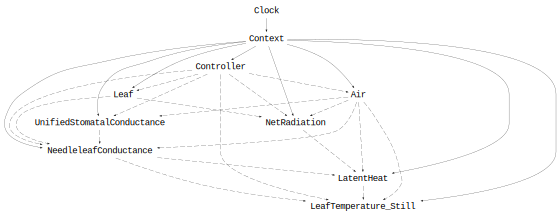

In [3]:
Cropbox.hierarchy(LeafTemperature_Still)

In [4]:
parameters(LeafTemperature_Still)

cp,=,1010 J kg^-1 K^-1
Mair,=,0.029 kg mol^-1
Mwater,=,0.018 kg mol^-1
R,=,8.314 J K^-1 mol^-1
λ,=,40660.0 J mol^-1
Ta,=,298 K
Pa,=,100 kPa
RH,=,0.5
α_LW,=,0.98
α_SW,=,0.5
d,=,0.01 m


We now demonstrate each of the subsystems. The `Air` system calculates atmospheric properties, especially those related to water content.

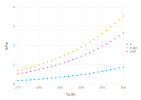

In [5]:
visualize(Air, :Ta, [:e, :e_sat, :vpd]; xstep = :0 => :Ta => 275:1:300, kind=:scatter, config = :0 => :RH => 0.25)

In [6]:
parameters(Air)

cp,=,1010 J kg^-1 K^-1
Mair,=,0.029 kg mol^-1
Mwater,=,0.018 kg mol^-1
R,=,8.314 J K^-1 mol^-1
λ,=,40660.0 J mol^-1
Ta,=,298 K
Pa,=,100 kPa
RH,=,0.5


The `Leaf` system is a simple system to hold onto physical properties of the leaf under study. These include absorbances for longwave and shortwave radiation and characteristic dimension.

In [7]:
parameters(Leaf)

α_LW,=,0.98
α_SW,=,0.5
d,=,0.01 m


Two systems are available to calculate conductance. `NeedleleafConductance` is defined empirically for a pine needle as given in the supplemental information in Still et al. (2022). `UnifiedStomatalConductance` implements the coupled relationship between VPD, photosynthesis, and stomatal conductance described in [Medlyn et al. (2011)](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1365-2486.2010.02375.x). Taken together, these couple physical and physiological drivers of transpiration.

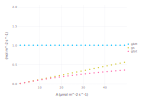

In [8]:
visualize(NeedleleafConductance, :A, [:gbH, :gs, :gtot]; xstep = :0 => :A => 1:2:50, kind=:scatter)

In [9]:
# Both of these systems need to know atmospheric conditions to work, so they carry over all the parameters from the Air system
parameters(NeedleleafConductance)

cp,=,1010 J kg^-1 K^-1
Mair,=,0.029 kg mol^-1
Mwater,=,0.018 kg mol^-1
R,=,8.314 J K^-1 mol^-1
λ,=,40660.0 J mol^-1
Ta,=,298 K
Pa,=,100 kPa
RH,=,0.5
α_LW,=,0.98
α_SW,=,0.5
d,=,0.01 m


In [10]:
parameters(UnifiedStomatalConductance)

cp,=,1010 J kg^-1 K^-1
Mair,=,0.029 kg mol^-1
Mwater,=,0.018 kg mol^-1
R,=,8.314 J K^-1 mol^-1
λ,=,40660.0 J mol^-1
Ta,=,298 K
Pa,=,100 kPa
RH,=,0.5
g0,=,0 mmol m^-2 s^-1
g1,=,2.35 kPa^1/2
Ca,=,400 μmol mol^-1


`NetRadiation` models the difference between ingoing and outgoing radiation fluxes. This system is implemented as an isothermal net radiation since it models the temperature of air on the skin of the leaf. This makes it easier to solve for leaf temperature directly and the authors claim it works better than using leaf temperature to calculate outgoing longwave.

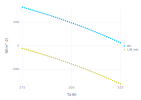

In [11]:
# Note that a negative flux means that the net flow of energy is out of the leaf.
visualize(NetRadiation, :Ta, [:Rn, :LW_net]; xstep = :0 => :Ta => 275:1:325, kind=:scatter)

In [12]:
parameters(NetRadiation)

cp,=,1010 J kg^-1 K^-1
Mair,=,0.029 kg mol^-1
Mwater,=,0.018 kg mol^-1
R,=,8.314 J K^-1 mol^-1
λ,=,40660.0 J mol^-1
Ta,=,298 K
Pa,=,100 kPa
RH,=,0.5
α_LW,=,0.98
α_SW,=,0.5
d,=,0.01 m


The final module is the latent heat flux. This system models stomatally-imposed and radiation-limited endpoints. Which endpoint dominates is determined by the ratio of conductances from the previous systems.

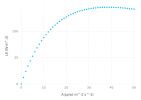

In [13]:
visualize(LatentHeat, :A, :LE, xstep = :0 => :A => 0:1:50, kind=:scatter)

In [14]:
parameters(LatentHeat)

cp,=,1010 J kg^-1 K^-1
Mair,=,0.029 kg mol^-1
Mwater,=,0.018 kg mol^-1
R,=,8.314 J K^-1 mol^-1
λ,=,40660.0 J mol^-1
Ta,=,298 K
Pa,=,100 kPa
RH,=,0.5
α_LW,=,0.98
α_SW,=,0.5
d,=,0.01 m


We now have all the pieces to build the final model! This last module calculates $dT = T_{leaf} - T_{air}$ since $dT$ is often more interesting than absolute leaf temperature. But, absolute temperature is also available through the variable `T_leaf`.

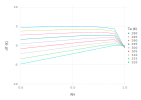

In [15]:
visualize(LeafTemperature_Still, :RH, :dT; 
    xstep = :0 => :RH => 0:0.1:1,
    group = :0 => :Ta => collect(280:5:320),
    kind=:line,
    ylim=(-10, 10)
)

In [16]:
parameters(LeafTemperature_Still)

cp,=,1010 J kg^-1 K^-1
Mair,=,0.029 kg mol^-1
Mwater,=,0.018 kg mol^-1
R,=,8.314 J K^-1 mol^-1
λ,=,40660.0 J mol^-1
Ta,=,298 K
Pa,=,100 kPa
RH,=,0.5
α_LW,=,0.98
α_SW,=,0.5
d,=,0.01 m


One challenge with manipulating this model is that we would like to manipulate the output of some subsystems as a parameter in a later subsystem. One strategy to overcome this is to define a dummy system on top of the final `LeafTemperature_Still` system where the desired value is set as a parameter. For example:

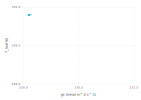

In [17]:
# Doesn't work because gs isn't a parameter in LeafTemperature_Still
include("leaf_eb_still.jl")
visualize(LeafTemperature_Still, :gs, :T_leaf, xstep = :0 => :gs => 10:10:400, kind=:scatter)

In [18]:
# Does work
@system dummy(Controller, LeafTemperature_Still) begin
    gs: stomatal_conductance => 400 ~ preserve(parameter, u"mmol / m^2 / s")
end

dummy

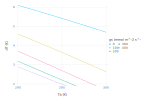

In [19]:
visualize(
    dummy, :Ta, :dT, 
    group = :0 => :gs => 0:100:400,
    xstep = :0 => :Ta => 290:1:300,
    kind = :line, ylim = (2, 6)
)

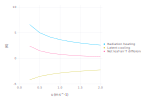

In [20]:
visualize(
    dummy, :u, [:dT_Rn, :dT_LE, :dT], 
    xstep = :0 => :u => 0:0.25:2,
    kind = :line,
    names = ["Radiation heating", "Latent cooling", "Net leaf-air T difference"],
    ylim = (-5, 10)
)